In [1]:
# 價格預測版本v3, 可完整處理model1的流程

In [2]:
import pandas as pd
import urllib.request
import os
import datetime
import numpy as np
import time
import csv

from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 農作物
crop_dict = {
    1 : ['cabbage', '高麗菜 (LA1 甘藍 初秋)'],
    2 : ['carrot', '胡蘿蔔 (SB2 胡蘿蔔 清洗)'],
    3 : ['beeftomato', '牛番茄 (FJ3 番茄 牛蕃茄)'],
    4 : ['cucumber', '胡瓜 (FD1 花胡瓜)'],
    5 : ['loofah', '絲瓜 (FF1 絲瓜)'],
    6 : ['cabbage2', '包心白菜 (LC1 包心白 包白)'],
    7 : ['shallots', '青蔥 (SE6 青蔥 粉蔥)'],
    8 : ['bittergourd', '苦瓜 (FG1 苦瓜 白大米)'],
    9 : ['onion', '洋蔥 (SD1 洋蔥 本產)'],
    10 : ['waterspinach', '空心菜 (LF2 蕹菜 小葉)'],

    11 : ['guava', '番石榴 (P1 番石榴 珍珠芭)'],
    12 : ['pineapple', '鳳梨 (B2 鳳梨 金鑽鳳梨)'],
    13 : ['papaya', '木瓜 (I1 木瓜 網室紅肉)'],
    14 : ['watermelon', '西瓜 (T1 西瓜 大西瓜)'],
    15 : ['banana', '香蕉 (A1 香蕉)'],
    16 : ['apple', '蘋果 (X69 蘋果 富士進口)'],
    17 : ['pear', '梨子 (O4 梨 新興梨)'],
    18 : ['grape', '葡萄 (S1 葡萄 巨峰)'],
    19 : ['dragonfruit', '火龍果 (812 火龍果 紅肉)'],
    20 : ['mango', '芒果 (R1 芒果 愛文)']
}

In [4]:
market_dict = {
    1 : '台北一'
}

In [5]:
# 選擇農產品，目前只有1, 15
crop_no = 15
# 選擇市場，目前只有1
market_no = 1
# 是否要加入天氣資料
add_weather_data = False
# 是否要加入颱風資料
add_typhoon_data = False
# 設定往前以及往後看的天數, pastDay, futureDay要設定一樣的值
pastDay = 15
futureDay = 15
# 畫多少天的預測圖，要小於或等於上面的數字
plotDay = 10
# 訂定訓練資料的期間、測試資料的期間
train_start_date = '2017-06-01'
train_end_date = '2020-05-31'
test_start_date = '2020-06-01'
test_end_date = '2021-06-30'
# 使用哪一個模型，目前有1, 2
model_no = 1
# 其它參數
batch_size = 128
epochs = 1000
validation_split = 0.1
# 記錄現在時間
datetime_now = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=+8))).strftime("%Y-%m-%dT%H:%M:%S")
# 是否要存入google drive
save_google = False
save_google_dir = '/content/drive/MyDrive/project/result/'

In [6]:
if save_google: drive.mount('/content/drive/', force_remount=True)

In [7]:
1# 檔案下載url
weather_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/reportdaily_mean_fillna.csv'
typhoon_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/TyphoonDatabase.csv'
cabbage_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/Cabbage.csv'
banana_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/Banana.csv'

In [8]:
# 將檔案下載至colab
if not os.path.exists('weather.csv'): urllib.request.urlretrieve(weather_data_url, 'weather.csv') 
if not os.path.exists('typhoon.csv'): urllib.request.urlretrieve(typhoon_data_url, 'typhoon.csv') 
if not os.path.exists('cabbage.csv'): urllib.request.urlretrieve(cabbage_data_url, 'cabbage.csv') 
if not os.path.exists('banana.csv'): urllib.request.urlretrieve(banana_data_url, 'banana.csv')

In [9]:
# 所有城市對照英文代碼
city = {
    '基隆市':'KLU',
    '臺北市':'TPE',
    '新北市':'TPH',
    '桃園市':'TYC',
    '新竹市':'HSC',
    '新竹縣':'HSH',
    '苗栗縣':'MAL',
    '臺中市':'TXG',
    '彰化縣':'CWH',
    '南投縣':'NTO',
    '雲林縣':'YLH',
    '嘉義市':'CYI',
    '嘉義縣':'CHY',
    '臺南市':'TNN',
    '高雄市':'KHH',
    '屏東縣':'IUH',
    '宜蘭縣':'ILN',
    '花蓮縣':'HWA',
    '臺東縣':'TTT'
}

In [10]:
# 要移除的欄位列表
# weather columb全部列表: 'date', 'city', 'StnPres', 'SeaPres', 'StnPresMax', 'StnPresMaxTime', 'StnPresMin', 'StnPresMinTime', 'Temperature', 'TMax', 'TMaxTime', 'TMin', 'TMinTime', 'TdDewPoint', 'RH', 'RHMin', 'RHMinTime', 'WS', 'WD', 'WSGust', 'WDGust', 'WGustTime', 'Precp', 'PrecpHour', 'PrecpMax10', 'PrecpMax10Time', 'PrecpMax60', 'PrecpMax60Time', 'SunShine', 'SunShineRate', 'GloblRad', 'VisbMean', 'EvapA', 'UVIMax', 'UVIMaxTime', 'CloudAmount'
weather_drop_columns = [
                        'StnPresMaxTime', 
                        'StnPresMinTime', 
                        'TMaxTime', 
                        'TMinTime', 
                        'RHMinTime', 
                        'WGustTime', 
                        'PrecpMax10', 
                        'PrecpMax10Time', 
                        'PrecpMax60', 
                        'PrecpMax60Time', 
                        'UVIMax', 
                        'UVIMaxTime'
]

In [11]:
# 讀取天氣資料
df = pd.read_csv('weather.csv', encoding='utf-8')
# 移除不需要的欄位
df = df.drop(weather_drop_columns, axis=1)
df.head(3)

,date,city,StnPres,SeaPres,StnPresMax,StnPresMin,Temperature,TMax,TMin,TdDewPoint,RH,RHMin,WS,WD,WSGust,WDGust,Precp,PrecpHour,SunShine,SunShineRate,GloblRad,VisbMean,EvapA,CloudAmount
0,2000-01-01,南投縣,773.0,1527.9,775.0,771.4,9.0,14.3,6.5,1.1,60.0,37.5,7.5,301.0,14.1,262.5,0.0,0.0,9.8,91.5,12.0,34.4,2.8,1.4
1,2000-01-01,嘉義市,1013.0,1016.3,1015.5,1010.1,18.9,26.0,13.4,14.3,77.0,41.0,2.0,20.0,8.4,30.0,0.0,0.0,7.6,71.2,9.4,4.6,2.8,1.8
2,2000-01-01,嘉義縣,874.2,3156.4,767.6,764.6,14.0,14.9,3.7,-3.6,44.0,18.0,1.8,300.0,6.3,90.0,0.0,0.0,9.2,96.5,18.4,44.2,2.1,0.5


In [12]:
# 使用index做merge，將weather表格依日期拉平
df_date = df['date'].drop_duplicates().to_frame().set_index('date')

for cityname, citycode in city.items():
    df_city = df.loc[df['city'] == cityname].add_suffix('_' + citycode).set_index('date' + '_' + citycode)
    df_date = pd.merge(df_date, df_city, how='left', left_index = True, right_index = True)

df_date = df_date[df_date.columns.drop(list(df_date.filter(regex='city')))]
df_weather = df_date

df_weather.head(3)

,StnPres_KLU,SeaPres_KLU,StnPresMax_KLU,StnPresMin_KLU,Temperature_KLU,TMax_KLU,TMin_KLU,TdDewPoint_KLU,RH_KLU,RHMin_KLU,WS_KLU,WD_KLU,WSGust_KLU,WDGust_KLU,Precp_KLU,PrecpHour_KLU,SunShine_KLU,SunShineRate_KLU,GloblRad_KLU,VisbMean_KLU,EvapA_KLU,CloudAmount_KLU,StnPres_TPE,SeaPres_TPE,StnPresMax_TPE,StnPresMin_TPE,Temperature_TPE,TMax_TPE,TMin_TPE,TdDewPoint_TPE,RH_TPE,RHMin_TPE,WS_TPE,WD_TPE,WSGust_TPE,WDGust_TPE,Precp_TPE,PrecpHour_TPE,SunShine_TPE,SunShineRate_TPE,...,Temperature_HWA,TMax_HWA,TMin_HWA,TdDewPoint_HWA,RH_HWA,RHMin_HWA,WS_HWA,WD_HWA,WSGust_HWA,WDGust_HWA,Precp_HWA,PrecpHour_HWA,SunShine_HWA,SunShineRate_HWA,GloblRad_HWA,VisbMean_HWA,EvapA_HWA,CloudAmount_HWA,StnPres_TTT,SeaPres_TTT,StnPresMax_TTT,StnPresMin_TTT,Temperature_TTT,TMax_TTT,TMin_TTT,TdDewPoint_TTT,RH_TTT,RHMin_TTT,WS_TTT,WD_TTT,WSGust_TTT,WDGust_TTT,Precp_TTT,PrecpHour_TTT,SunShine_TTT,SunShineRate_TTT,GloblRad_TTT,VisbMean_TTT,EvapA_TTT,CloudAmount_TTT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,1009.2,1016.9,1011.0,1007.2,19.3,22.6,16.9,14.3,73.5,63.0,3.8,280.0,10.6,180.0,2.2,0.4,3.8,36.6,5.6,13.9,2.0,6.0,996.4,1184.6,998.6,994.4,17.5,21.1,14.3,11.9,78.7,51.0,1.2,230.9,7.2,197.3,0.0,0.0,2.7,25.9,...,18.5,24.9,13.5,16.4,74.0,58.0,0.8,221.7,4.5,162.7,0.5,0.0,4.1,37.0,7.9,12.8,1.2,7.4,956.6,1015.0,989.5,982.9,19.2,25.0,17.7,16.9,74.8,61.8,1.8,119.2,7.2,75.2,0.0,0.0,3.1,28.9,7.6,15.5,2.9,7.1
2000-01-02,1010.9,1018.6,1012.6,1008.8,18.6,21.7,15.2,11.4,64.5,54.5,4.7,130.0,11.7,85.0,0.0,0.0,8.5,79.8,8.0,9.3,2.6,3.8,997.6,1187.6,999.4,995.2,16.8,22.6,12.1,9.0,68.7,43.3,1.9,98.3,10.0,93.7,0.0,0.0,7.6,71.9,...,17.9,23.0,14.6,13.7,62.0,42.0,1.1,215.7,6.7,139.9,0.3,0.0,2.6,23.0,7.2,13.0,1.5,9.0,957.0,1015.9,976.0,971.3,17.9,22.1,16.5,14.1,64.0,50.2,2.8,119.8,11.4,89.7,0.0,0.0,4.2,38.9,8.5,14.6,3.6,6.9
2000-01-03,1011.0,1018.6,1012.9,1009.2,18.7,20.8,16.3,10.0,58.0,48.0,3.9,60.0,10.3,85.0,0.0,0.0,5.0,47.4,7.0,8.8,3.0,5.1,997.1,1185.5,999.0,995.4,17.6,20.8,15.3,10.7,76.7,62.3,2.3,79.2,10.3,89.0,0.0,0.0,4.6,43.2,...,16.7,22.1,12.9,13.5,67.0,56.0,0.8,210.9,4.8,172.4,0.1,0.0,1.8,16.7,5.0,10.3,2.5,8.5,958.2,1016.9,989.8,986.6,16.9,22.2,16.2,13.5,64.2,56.5,2.2,101.1,9.8,66.7,0.0,0.0,5.2,47.8,8.0,13.1,3.2,6.5


In [13]:
# 計算兩個日期間隔多少天
def daysBetweenDate(startdate: str, enddate: str) -> int:
    startdate = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    enddate = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    days = (enddate - startdate).days + 1
    return days

# 日期調整
def dateShift(startdate: str, shiftday: int) -> str:
    startdate = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    targetdate = startdate + datetime.timedelta(days=shiftday)
    return datetime.datetime.strftime(targetdate, "%Y-%m-%d")

# 讀取颱風資料庫
df_typhoon = pd.read_csv('typhoon.csv', encoding='utf-8')

# 將Warning的日期文字轉為4個欄位'startdate','starttime','enddate','endtime'
df_typhoon[['startdate','starttime','enddate','endtime']] = df_typhoon['Warning'].str.split().tolist()
# 將最前面塞入date欄位
df_typhoon_new = pd.DataFrame(columns=df_typhoon.columns.insert(0, 'date'))

# 將所有颱風按日期列出
# 使用iterrows
start_time = time.time()
for index, row in df_typhoon.iterrows():
    days = daysBetweenDate(row['startdate'], row['enddate'])
    for day in range(0, days):
        date = dateShift(row['startdate'],day)
        datesr1 = pd.Series(date).append(df_typhoon.iloc[index]).rename({0: 'date'})
        df_typhoon_new = df_typhoon_new.append(datesr1, ignore_index=True)

# 將相同日期的去除並暫時只留WarnMark欄位
df_typhoon_wm = pd.DataFrame(df_typhoon_new, columns=['date'])
df_typhoon_wm['WarnMark'] = 1
df_typhoon_wm = df_typhoon_wm.drop_duplicates().reset_index().drop(columns=['index'])

df_typhoon = df_typhoon_wm.set_index('date')

print(df_typhoon.head(3))


            WarnMark
date                
2021-06-03         1
2021-06-04         1
2020-11-05         1


In [14]:
# 要移除的欄位列表
# market columns 全部列表: 'Date', 'Market', 'Product', 'Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume', 'Month', 'Week_day', 'Year', 'Rest_day'
market_drop_columns = [
                       'Up_price', 
                       'Mid_price',
                       'Low_price'
]

In [15]:
# 讀取農產品資料
csv_name = crop_dict[crop_no][0] + '.csv'
df = pd.read_csv(csv_name, encoding='utf-8')
# 移除不需要的欄位
df = df.drop(market_drop_columns, axis=1)
df.head(3)

,Date,Market,Product,Avg_price,Volume,Month,Week_day,Year,Rest_day
0,2000-01-01,嘉義市,A1 香蕉,12.0,650.0,1,6,2000,0
1,2000-01-02,嘉義市,A1 香蕉,12.0,760.0,1,7,2000,0
2,2000-01-03,嘉義市,A1 香蕉,12.0,810.0,1,1,2000,0


In [16]:
# 將休市價格填入前一日價格
df = df.fillna(method="ffill")
# 只拿出指定市場的資料
df = df[df.Market == market_dict[market_no]]

df = df.dropna()
df_crop = df.rename(columns={'Date': 'date'}).set_index('date')

print(df_crop.head(3))
print(df_crop.tail(3))

           Market  Product  Avg_price   Volume  Month  Week_day  Year  Rest_day
date                                                                           
2000-01-02    台北一  A1 香蕉         20.2  22319.0      1         7  2000         0
2000-01-03    台北一  A1 香蕉         19.5  15810.0      1         1  2000         0
2000-01-04    台北一  A1 香蕉         20.3  15126.0      1         2  2000         0
           Market  Product  Avg_price   Volume  Month  Week_day  Year  Rest_day
date                                                                           
2021-06-17    台北一  A1 香蕉         23.2  18276.0      6         4  2021         0
2021-06-18    台北一  A1 香蕉         20.9  14040.0      6         5  2021         0
2021-06-19    台北一  A1 香蕉         24.8  13485.0      6         6  2021         0


In [17]:
df_all = df_crop
# 是否要合併天氣資料
if add_weather_data:
  df_all = pd.merge(df_all, df_weather, how='inner', left_index = True, right_index = True)
# 是否要合併颱風資料
if add_typhoon_data:
  df_all = pd.merge(df_all, df_typhoon, how='left', left_index = True, right_index = True).fillna(0)

# 把平均價格移到最後1欄
col_Avg_price = df_all.pop('Avg_price')
df_all = pd.concat([df_all, col_Avg_price], 1)
print(df_all.head(3))
print(df_all.tail(3))

           Market  Product   Volume  Month  Week_day  Year  Rest_day  Avg_price
date                                                                           
2000-01-02    台北一  A1 香蕉    22319.0      1         7  2000         0       20.2
2000-01-03    台北一  A1 香蕉    15810.0      1         1  2000         0       19.5
2000-01-04    台北一  A1 香蕉    15126.0      1         2  2000         0       20.3
           Market  Product   Volume  Month  Week_day  Year  Rest_day  Avg_price
date                                                                           
2021-06-17    台北一  A1 香蕉    18276.0      6         4  2021         0       23.2
2021-06-18    台北一  A1 香蕉    14040.0      6         5  2021         0       20.9
2021-06-19    台北一  A1 香蕉    13485.0      6         6  2021         0       24.8


In [18]:
# 建立訓練資料，將資料整理為x_train, y_train
def buildTrain(train, pastDay=30, futureDay=5):
  x_train, y_train = [], []
  for i in range(train.shape[0]-futureDay-pastDay):
    # i+pastDay = 本日
    x_train.append(train[i:i+pastDay])
    y_train.append(train[i+pastDay:i+pastDay+futureDay, -1])
  return np.array(x_train), np.array(y_train)

In [19]:
# 將資料切分為訓練資料及驗證資料
def splitData(X,Y,rate):
  X_train = X[:int(X.shape[0]*(1-rate))]
  Y_train = Y[:int(Y.shape[0]*(1-rate))]
  X_val = X[int(X.shape[0]*(1-rate)):]
  Y_val = Y[int(Y.shape[0]*(1-rate)):]

  return X_train, Y_train, X_val, Y_val

In [20]:
# 將資料複製一份來作業, 將欄位index改為date
df = df_all.copy()
df = df.reset_index().rename(columns={'index': 'date'})

# 依訓練資料的期間、測試資料的期間來切分資料
df_train = df.iloc[df[(train_start_date <= df.date) & (df.date <= train_end_date)].index].set_index('date')
df_test = df.iloc[df[(test_start_date <= df.date) & (df.date <= test_end_date)].index].set_index('date')

# 將非數字的欄位移除
df_train = df_train.select_dtypes(exclude=['object'])
df_test = df_test.select_dtypes(exclude=['object'])

print(df_train.dtypes)

Volume       float64
Month          int64
Week_day       int64
Year           int64
Rest_day       int64
Avg_price    float64
dtype: object


In [21]:
# 設定x_train, y_train的scaler
x_sc = MinMaxScaler()
y_sc = MinMaxScaler()

# 將訓練資料做MinMaxScaler
# 先將y_train fit MinMaxScaler，待未來使用
x_sc.fit(df_train)
y_train = df_train['Avg_price']
y_sc.fit(y_train.to_frame())

df_train_scaled = x_sc.transform(df_train)

# 製作x_train, y_train
x_train, y_train = buildTrain(df_train_scaled, pastDay, futureDay)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (1066, 15, 6)
y_train shape: (1066, 15)


In [22]:
# 模型建立
def buildManyToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  model.add(TimeDistributed(Dense(1)))
  # https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras
  # model.add(Lambda(lambda x: x[:, -7:, :])) #Select last N from output
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [23]:
# 模型2
def buildManyToManyModel2(shape):
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(shape[1], shape[2])))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [24]:
# 模型3
def buildManyToManyModel3(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  # model.add(TimeDistributed(Dense(1)))
  # https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras
  model.add(Lambda(lambda x: x[:, pastDay*-1:, :])) #Select last N from output
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [25]:
# 模型
model_dict = {
    1 : [buildManyToManyModel, 'LSTM many to many'],
    2 : [buildManyToManyModel2, 'LSTM many to one'],
    3 : [buildManyToManyModel3, 'LSTM many to many'],
    4 : ['', ''],

}

In [26]:
# 將資料切分為訓練資料及驗證資料
x_train, y_train, x_val, y_val = splitData(x_train, y_train, validation_split)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

# 將資料由2D改為3D
y_train = y_train[:,:,np.newaxis]
y_val = y_val[:,:,np.newaxis]
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

x_train shape: (959, 15, 6)
y_train shape: (959, 15)
x_val shape: (107, 15, 6)
y_val shape: (107, 15)
y_train shape: (959, 15, 1)
y_val shape: (107, 15, 1)


In [27]:
# 模型訓練
try:
  model = model_dict[model_no][0](x_train.shape)
  print('model_no:', model_no)
except Exception as e:
	print('model選錯了, except:', e)

callback = EarlyStopping(monitor="loss", patience=10, verbose=2, mode="auto")
model.fit(x_train, y_train, epochs=1000, batch_size=128, validation_data=(x_val, y_val), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 10)            680       
_________________________________________________________________
time_distributed (TimeDistri (None, 15, 1)             11        
Total params: 691
Trainable params: 691
Non-trainable params: 0
_________________________________________________________________
model_no: 1
Epoch 1/1000
8/8 [==============================] - 22s 134ms/step - loss: 0.1426 - val_loss: 0.1512
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0761 - val_loss: 0.0815
Epoch 3/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0408 - val_loss: 0.0516
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0301 - val_loss: 0.0434
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0307 - val_loss: 0.0422
Epoch 6/1000
8/

In [28]:
# 儲存模型
if save_google: model.save(save_google_dir + (datetime_now) + '.h5')

In [29]:
# 建立測試資料，將資料整理為x_test, y_test, y_real
def buildTest(test, pastDay, futureDay):
  x_test, y_test, y_real = [], [], []
  for i in range(test.shape[0]-futureDay-pastDay):
    # i+pastDay = 本日
    x_test.append(test[i:i+pastDay])
    y_test.append(test[i+pastDay:i+pastDay+futureDay, -1])
    y_real.append(test[i+pastDay][-1])
    # y_real.append(test[i][-1])
 
  return np.array(x_test), np.array(y_test), np.array(y_real)

In [30]:
# 將x_test做MinMaxScaler
df_test_scaled = x_sc.transform(df_test)
print(df_test_scaled.shape)

# 將資料切為x_test, y_test
x_test, y_test, y_real = buildTest(df_test_scaled, pastDay, futureDay)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print('y_real shape:', y_real.shape)

(384, 6)
x_test shape: (354, 15, 6)
y_test shape: (354, 15)
y_real shape: (354,)


In [31]:
# 執行價格預測
x_test_pred = model.predict(x_test)
print('x_test_pred.shape:', x_test_pred.shape)

x_test_pred_shape = x_test_pred.reshape(x_test_pred.shape[0], x_test_pred.shape[1])
print('x_test_pred_shape.shape', x_test_pred_shape.shape)
y_real_shape = y_real.reshape(y_real.shape[0], 1)
print('y_real.shape', y_real.shape)
# 將預測值轉換回實際價格
x_test_pred_price = y_sc.inverse_transform(x_test_pred_shape)
y_real_price = y_sc.inverse_transform(y_real_shape)

# 建立可視的價格預測表
# daycolumn_x = ['D' + str(x) for x in list(range(1, futureDay+1))]
# daycolumn_y = ['D0']
# print('預測價格：\n', pd.DataFrame(x_test_pred_price[:,:futureDay], columns=daycolumn_x))
# print('實際價格：\n', pd.DataFrame(y_real_price[:futureDay], columns=daycolumn_y))

x_test_pred.shape: (354, 15, 1)
x_test_pred_shape.shape (354, 15)
y_real.shape (354,)


In [32]:
print('x_test.shape:', x_test_pred.shape)
print('y_test.shape:', y_test.shape)
score = model.evaluate(x_test, y_test, verbose = 0) 
score

x_test.shape: (354, 15, 1)
y_test.shape: (354, 15)


0.04171480983495712

In [33]:
# 畫圖
def drawResult(true_value, pred_value, plotDay):
  for i in range(plotDay):
    # i + 1 = 未來1日的價格
    Dday = i + 1
    real_price = true_value
    pred_price = pred_value[:,i:Dday]
    for j in range(Dday):
      pred_price = np.insert(pred_price, 0, None)
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)

    ax.plot(real_price, label='real price')
    ax.plot(pred_price, label='pred price')

    ax.set(xlabel='day', ylabel='price', title='predict D' + str(Dday) + ' price')
    ax.legend()
    ax.grid()

    if save_google: plt.savefig(save_google_dir + datetime_now + '_D' + str(Dday) + '.png')

    plt.show()

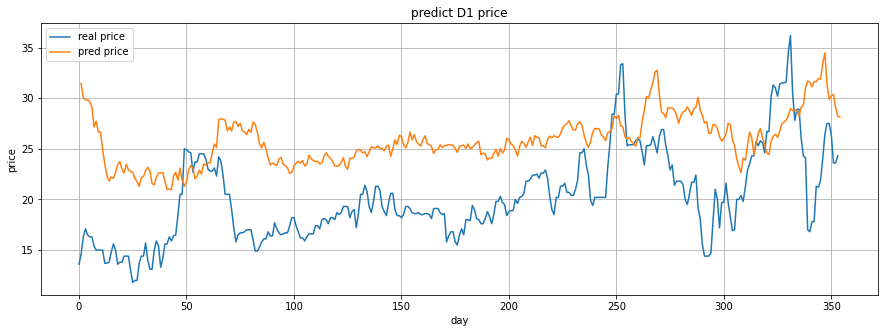

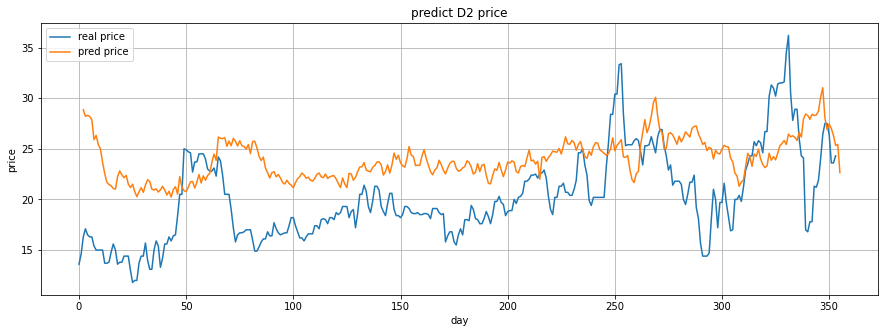

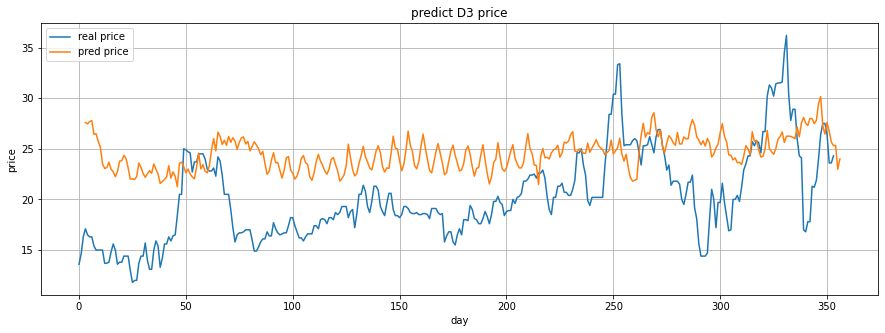

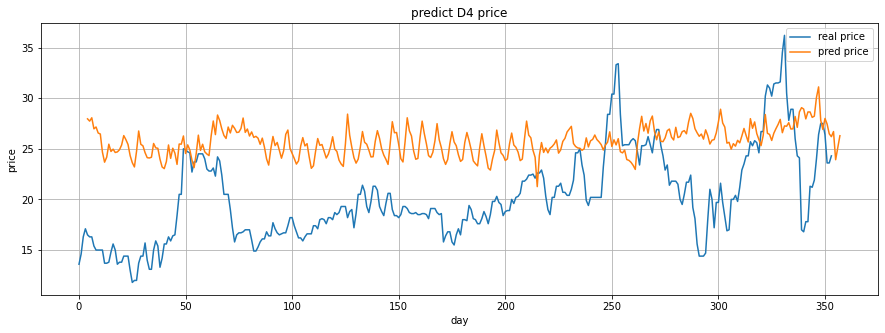

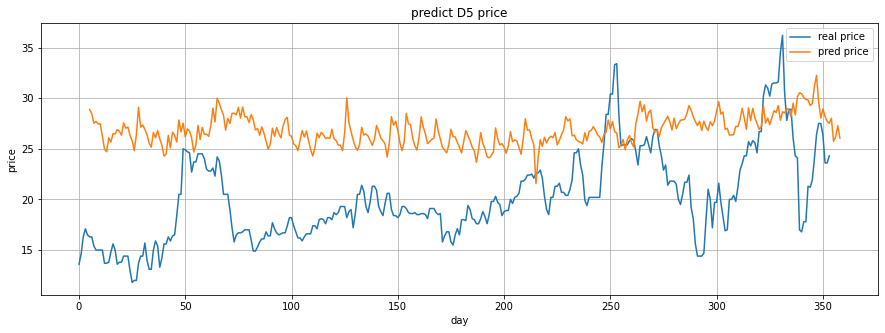

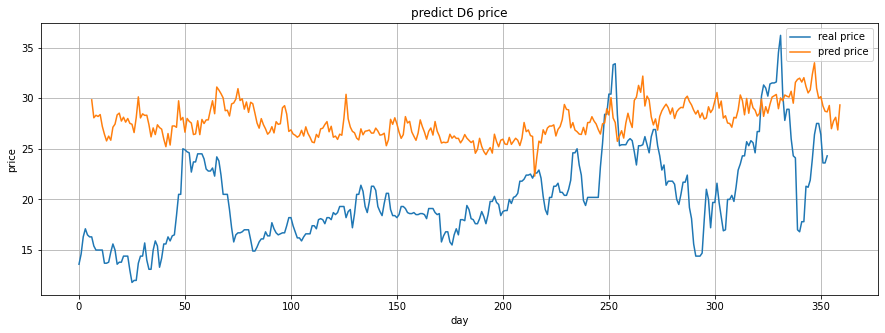

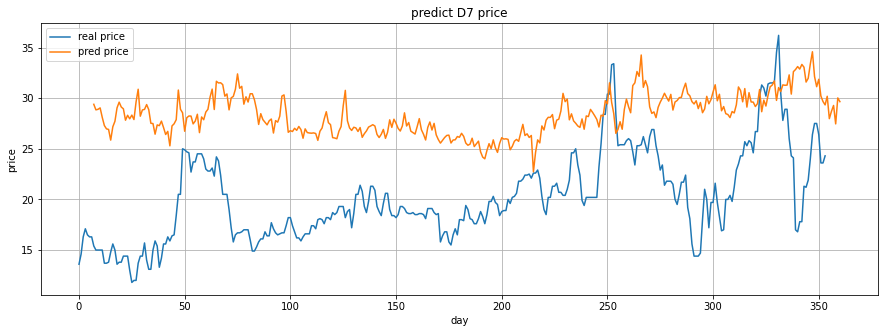

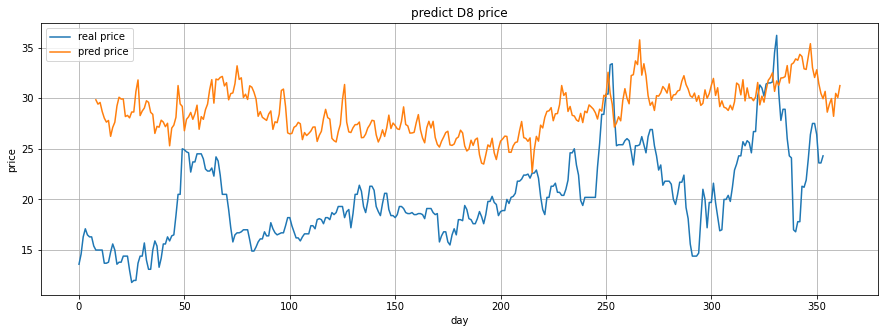

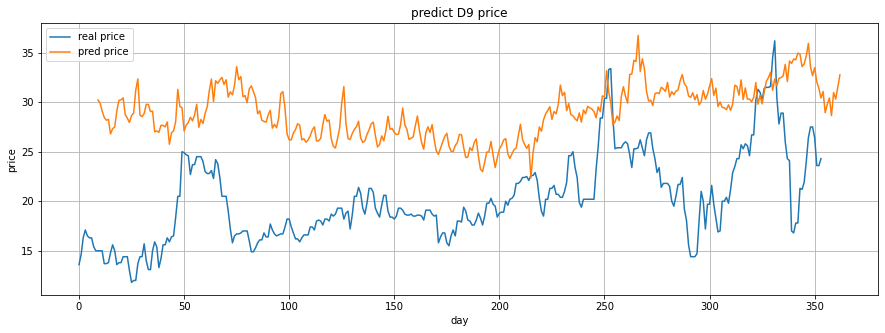

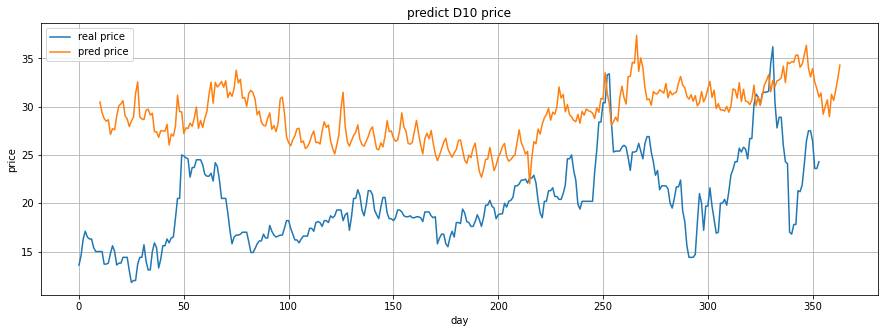

In [34]:
# 畫圖
pp = x_test_pred_price
rp = y_real_price

drawResult(rp, pp, plotDay)


In [35]:
# 記錄結果
result_column_lists = ['datetime', 'crop_name', 'market_name', 'add_weather_data', 'add_typhoon_data', 'train_start_date', 'model_no', 'model_name', 'pastDay', 'futureDay', 'batch_size', 'epochs', 'validation_split', 'predDay', 'MSE', 'RMSE', 'R2']

def saveResult(path, preDay, real_value, pred_value):
  with open(path, 'a', newline='', encoding='utf-8') as f:
    result_writer = csv.writer(f)
    if f.tell()==0: result_writer.writerow(result_column_lists)
    for i in range(preDay):
      # i + 1 = 未來1日的價格
      Dday = i + 1
      real_price = real_value[Dday:]
      pred_price = pred_value[:-Dday,i]

      MSE = mean_squared_error(real_price, pred_price)
      RMSE = np.sqrt(MSE)
      R2 = r2_score(real_price, pred_price)
      
      result_lists = [datetime_now, crop_dict[crop_no][1], market_dict[market_no], add_weather_data, add_typhoon_data, train_start_date, model_no, model_dict[model_no][1], pastDay, futureDay, batch_size, epochs, validation_split, Dday, MSE, RMSE, R2]
      result_writer.writerow(result_lists)

In [36]:
# 儲存結果
saveResult('result.csv', futureDay, rp, pp)
if save_google: saveResult(save_google_dir + 'result.csv', futureDay, rp, pp)

In [37]:
## code會在這兒停止
# class StopExecution(Exception):
#   def _render_traceback_(self):
#     pass

# raise StopExecution

In [38]:
###############################以下是參考###############################################

In [39]:
# https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
# The input to every LSTM layer must be three-dimensional.

# The three dimensions of this input are:

# Samples. One sequence is one sample. A batch is comprised of one or more samples.
# Time Steps. One time step is one point of observation in the sample.
# Features. One feature is one observation at a time step.